In [20]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np

# 필요한 라이브러리 임포트
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

### 1. train_data(AI-Hub 상담대화, 신고전화(구조,화재,구급,기타), SNS대화, 채팅대화 추가) 필터링 하기 전 Data

In [21]:
train_data = pd.read_csv('/workspace/Result_12.10/train_preproc_origin.csv')
train_data

,idx,class,conversation
0,0,일반 대화,너희 오토바이 타봤어? 이번에 친구가 오토바이 사서 자랑하는데 너무 부럽더라 나는 ...
1,1,일반 대화,나 연수 좀 도와줘 운전 연수 말하는 거야? 하.. 또 이 베스트 드라이버가 나설 ...
2,2,일반 대화,나 이번 주에 할머니 집 가. 그래? 오랜만에 할머니도 보고 좋겠네. 그러게 할머니...
3,3,일반 대화,학교 등교할 때 택시 타고 등교하는데 차가 너무 많이 막혀 맞아 요즘 차가 너무 막...
4,4,일반 대화,오늘 등굣길에 버스를 탔는데 사람이 너무 많았어. 학생들 등교 시간이라 사람이 많은...
...,...,...,...
4945,4945,기타 괴롭힘 대화,준하야 넌 대가리가 왜 이렇게 크냐? 내 머리가 뭐. 밥 먹으면 대가리만 크냐 너는...
4946,4946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내 예.? ...
4947,4947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지. 왜 그래. 들리겠어...
4948,4948,갈취 대화,누구 맘대로 여기서 장사하래? 이게 무슨 일입니까? 남의 구역에서 장사하려면 자릿세...


In [22]:
# 데이터 로드
data = train_data

class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

# 클래스 이름을 숫자로 변환
data['label'] = data['class'].map(class_mapping)
data = data.drop(columns=['class'])
data

,idx,conversation,label
0,0,너희 오토바이 타봤어? 이번에 친구가 오토바이 사서 자랑하는데 너무 부럽더라 나는 ...,4
1,1,나 연수 좀 도와줘 운전 연수 말하는 거야? 하.. 또 이 베스트 드라이버가 나설 ...,4
2,2,나 이번 주에 할머니 집 가. 그래? 오랜만에 할머니도 보고 좋겠네. 그러게 할머니...,4
3,3,학교 등교할 때 택시 타고 등교하는데 차가 너무 많이 막혀 맞아 요즘 차가 너무 막...,4
4,4,오늘 등굣길에 버스를 탔는데 사람이 너무 많았어. 학생들 등교 시간이라 사람이 많은...,4
...,...,...,...
4945,4945,준하야 넌 대가리가 왜 이렇게 크냐? 내 머리가 뭐. 밥 먹으면 대가리만 크냐 너는...,3
4946,4946,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내 예.? ...,1
4947,4947,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지. 왜 그래. 들리겠어...,2
4948,4948,누구 맘대로 여기서 장사하래? 이게 무슨 일입니까? 남의 구역에서 장사하려면 자릿세...,1


### 2. 욕설 필터링 (적용전 vs 후) 비교
- 욕설 단어만 제거
- 욕설 목록은 https://namu.wiki/w/%EC%9A%95%EC%84%A4/%ED%95%9C%EA%B5%AD%EC%96%B4를 참고하였고, 추가로 GPT를 활용하여 욕설 단어를 빠르게 발췌했습니다.
- 학습 및 평가에서 Train, Val data를 분석 학습에 부정적인 영향을 주는 단어를 필터링 하였습니다.(데이터 분석 및 GPT 유사 문맥 단어 발췌)
- 죽어와 같은 단어는 '협박' 클래스로 분류할 확률이 높기때문에 bad_words에서 제거하였습니다.

In [23]:
# 욕설 & 필터링 리스트
bad_words = [
    '씨발', '시발', '씨팔', '개새끼', '새끼', '니미', '병신', '엿', '미친', '꺼져',           #'죽어'
    '닥쳐', '좆', '지랄', '썅', '멍청이', '멍충이', '등신', '바보', '저능아',  # '뒈져'
    '천치', '돌아이', '모지리', '개자식', '미친놈', '미친년', '똘아이', '씹새끼',        #'죽어라',
    '씹년', '걸레', '창녀', '양아치', '호로', '호로새끼', '망나니', '상놈', '하놈',
    '쌍놈', '쌍년', '개잡놈', '쌍판때기', '돌대가리', '골빈놈', '돌머리', '꼴통', '양놈', '돌쇠',
    '돌대가리', '천박한놈', '개돼지', '쓰레기새끼', '개똥', '구제불능', '미친개', '미친돼지',
    '허접', '불쌍한놈', '재수없는놈', '찌질이', '껄렁이', '노답', '개망나니', '하류인간',
    '개망신', '망할놈', '몰상식한놈', '무식한놈', '개같은놈', '얼간이', '어리석은놈',
    '노양심', '양심없는놈', '배은망덕한놈', '정신나간놈', '개같은년', '뒤통수치는놈', '꼬라지',
    '더러운놈', '비열한놈', '천박한년', '가난뱅이', '천박한자식', '못난놈', '구질구질한놈',
    '쓰레기인간', '부정직한놈', '냄새나는놈', '무개념', '몰지각한놈', '놈',
    # 2번 클래스 고위 직급 단어, 회사용어
    '사장', '사장님', '사장한테', '차장', '차장님', '부장', '부장님', '과장', '과장님', '님', '회의', '프레젠테이션',
    # 실제로는 전혀 문제가 되는 말이 아니나, 모델이 어감을 부정적으로 받아들인 단어
    '정신분열증', '정신병', '양극성 장애', '우울증', '공황장애', '불안장애', '조현병',
    '범죄', '장애인', '신체장애', '지적장애', '시각장애', '청각장애',
]

# 욕설 & 필터링 함수
def remove_bad_words(text):
    for bad_word in bad_words:
        text = text.replace(bad_word, '')
    return text

# 데이터 로드
# train_data = pd.read_csv('train.csv')

# 욕설 제거
data['conversation'] = data['conversation'].apply(remove_bad_words)
data

,idx,conversation,label
0,0,너희 오토바이 타봤어? 이번에 친구가 오토바이 사서 자랑하는데 너무 부럽더라 나는 ...,4
1,1,나 연수 좀 도와줘 운전 연수 말하는 거야? 하.. 또 이 베스트 드라이버가 나설 ...,4
2,2,나 이번 주에 할머니 집 가. 그래? 오랜만에 할머니도 보고 좋겠네. 그러게 할머니...,4
3,3,학교 등교할 때 택시 타고 등교하는데 차가 너무 많이 막혀 맞아 요즘 차가 너무 막...,4
4,4,오늘 등굣길에 버스를 탔는데 사람이 너무 많았어. 학생들 등교 시간이라 사람이 많은...,4
...,...,...,...
4945,4945,준하야 넌 대가리가 왜 이렇게 크냐? 내 머리가 뭐. 밥 먹으면 대가리만 크냐 너는...,3
4946,4946,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내 예.? ...,1
4947,4947,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지. 왜 그래. 들리겠어...,2
4948,4948,누구 맘대로 여기서 장사하래? 이게 무슨 일입니까? 남의 구역에서 장사하려면 자릿세...,1


In [24]:
# 결과 저장
prepare = data
output_path = "/workspace/Result_12.10/prepare_test_fitering.csv"  # 결과 저장 경로
prepare.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /workspace/Result_12.10/prepare_test_fitering.csv


### 3. train, validation 데이터셋 분리

In [25]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['conversation'], data['label'], test_size=0.2, random_state=1
)

In [26]:
train_texts

4288    야 나 바쁘니깐 네가 이것 좀 해 이건 제 일이 아닌데요 예전에 했던 일이잖아 시키...
1038    팀장 오늘 당직이시죠? 그런데? 아 직원 부모 상당했다고 문자 한통 전 직원들에게 ...
1907    이거 자료 본인이 만들었어요? 혼자서 도움도 안 받고? 예. 저도 여기 있은 지 꽤...
518     솔직히 진짜 충격이었지. 많이 무섭고 힘들었겠어요. 그런 상황에서는 누구나 놀랐을 ...
4861    야 돼지야 너 머 하냐. 나 티브이 보는데 왜? 그러니까 네가 돼지인 거야. 운동 ...
                              ...                        
2895    이번 건은 배임의 위험이 있습니다. 그래서 뭐 하지 않으시는 게 넌 돈 많단 거지?...
2763    선호야 나 만 원만 빌려줘 너 저번에 빌려준 돈도 안 갚았잖아 그때 빌린 것까지 합...
905      네 119입니다 아 네 문의 좀 드릴게요 그 가정집에 그 합선 때문에 잠깐 화재가...
3980    . 혹시 오늘만 반차 쓰면 안 되겠습니다. 왜? 어디 아파? 몸살이 심하게 난 가 ...
235      지브리 거는 노래가 좋아.. 어 맞아 나는 가끔 틀어둔다 키키 특유의 색감이랑 그...
Name: conversation, Length: 3960, dtype: object

In [28]:
# KoBigBird용 데이터셋 생성
class KoBigBirdDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        # 토크나이저로 텍스트를 인코딩
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # input_ids, attention_mask 반환
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


### 4. KoBigBird 모델 및 토크나이저 로드

In [29]:
model_name = "monologg/kobigbird-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [30]:
# 데이터셋 생성
train_dataset = KoBigBirdDataset(train_texts, train_labels, tokenizer)
val_dataset = KoBigBirdDataset(val_texts, val_labels, tokenizer)

In [31]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의 및 로드 & GPU로 이동
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
model = model.to(device)  # 모델을 GPU에 올림

print(f"모델이 로드된 장치: {device}")

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델이 로드된 장치: cuda


### 5. 내재된 드랍아웃 비율 조정

In [32]:
# 드롭아웃 비율 수정
model.config.hidden_dropout_prob = 0.5 # 기존 0.1 -> 0.5으로 변경 (과적합 방지)
model.config.attention_probs_dropout_prob = 0.5

# 수정된 드롭아웃 비율 확인
print(f"Modified Hidden Dropout Probability: {model.config.hidden_dropout_prob}")
print(f"Modified Attention Dropout Probability: {model.config.attention_probs_dropout_prob}")

Modified Hidden Dropout Probability: 0.5
Modified Attention Dropout Probability: 0.5


In [33]:
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

### 6. 옵티마이저 및 손실함수 설정

In [34]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.01)

criterion = torch.nn.CrossEntropyLoss()

In [35]:
# NaN 값 확인
print(train_data.isnull().sum())
nan_rows = train_data[train_data.isnull().any(axis=1)]
print(nan_rows)

idx             0
class           0
conversation    0
label           0
dtype: int64
Empty DataFrame
Columns: [idx, class, conversation, label]
Index: []


### 7. 학습 루프, 모델 체크포인트 설정

In [36]:
# 학습 루프 2차 모델 체크포인트 설정
epochs = 15
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_loss = float('inf')  # 최적 손실 초기화
checkpoint_path = "/workspace/Result_12.10/best_model_checkpoint_Filtered_1201.pth"  # 체크포인트 저장 경로

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 모델 출력 및 손실 계산
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # 역전파
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 정확도 계산
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # 에포크별 손실 및 정확도 저장
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracies.append(correct / total)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")

    # 검증 손실 및 정확도 계산
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # 체크포인트 저장
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1} with val loss {avg_val_loss:.4f}")

# 체크포인트 불러오기
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    print(f"Checkpoint loaded. Starting at epoch {start_epoch} with best loss {best_loss:.4f}")
    return model, optimizer, start_epoch, best_loss

# 체크포인트 불러오기 예시
# model, optimizer, start_epoch, best_loss = load_checkpoint(model, optimizer, checkpoint_path)

Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Epoch 1/15, Train Loss: 1.5701, Train Accuracy: 0.3402
Epoch 1/15, Val Loss: 1.5070, Val Accuracy: 0.7101
Checkpoint saved at epoch 1 with val loss 1.5070
Epoch 2/15, Train Loss: 1.3666, Train Accuracy: 0.7073
Epoch 2/15, Val Loss: 1.1879, Val Accuracy: 0.8253
Checkpoint saved at epoch 2 with val loss 1.1879
Epoch 3/15, Train Loss: 1.0050, Train Accuracy: 0.8136
Epoch 3/15, Val Loss: 0.8134, Val Accuracy: 0.8404
Checkpoint saved at epoch 3 with val loss 0.8134
Epoch 4/15, Train Loss: 0.7428, Train Accuracy: 0.8439
Epoch 4/15, Val Loss: 0.6084, Val Accuracy: 0.8626
Checkpoint saved at epoch 4 with val loss 0.6084
Epoch 5/15, Train Loss: 0.5912, Train Accuracy: 0.8621
Epoch 5/15, Val Loss: 0.4940, Val Accuracy: 0.8798
Checkpoint saved at epoch 5 with val loss 0.4940
Epoch 6/15, Train Loss: 0.4880, Train Accuracy: 0.8795
Epoch 6/15, Val Loss: 0.4112, Val Accuracy: 0.8939
Checkpoint saved at epoch 6 with val loss 0.4112
Epoch 7/15, Train Loss: 0.4218, Train Accuracy: 0.8914
Epoch 7/15, Val

### 8. Train, Val_Loss, Accuracy 시각화

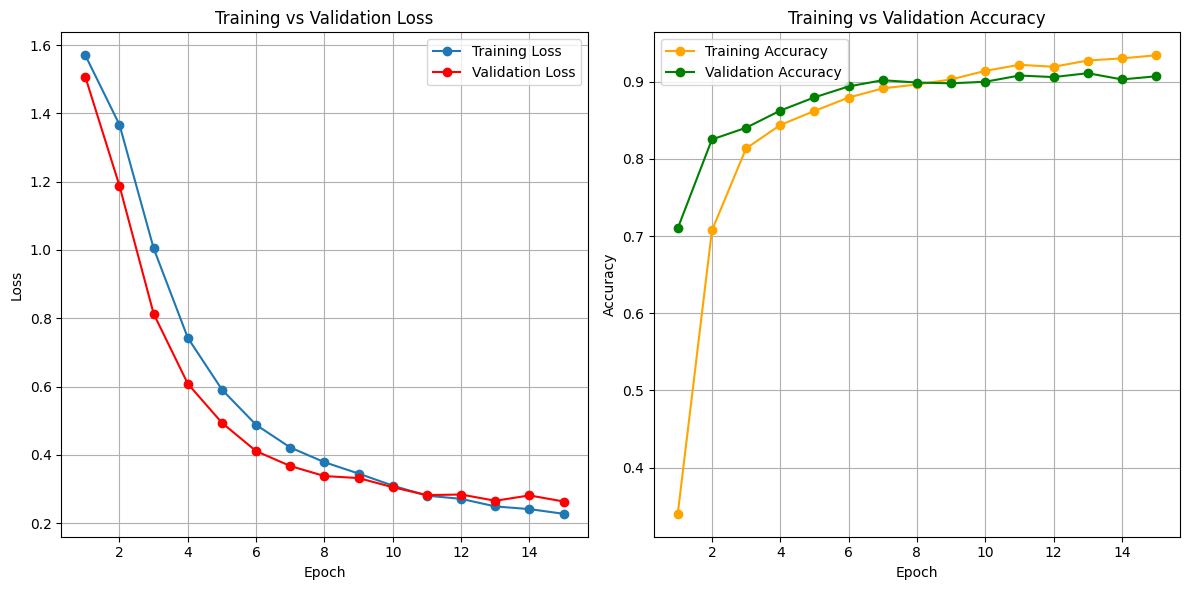

In [38]:
import matplotlib.pyplot as plt

# 손실 및 정확도 그래프
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, marker='o', label="Validation Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label="Training Accuracy", color='orange')
plt.plot(range(1, epochs + 1), val_accuracies, marker='o', label="Validation Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### 9. 최적의 모델 성능을 바탕으로 한 F1 score 평가(일반대화 제외)

In [39]:
from sklearn.metrics import f1_score, classification_report
import torch

# 모델 로드
checkpoint_path = "/workspace/Result_12.10/best_model_checkpoint_Filtered_1201.pth"  # 최적의 모델이 저장된 경로
model.load_state_dict(torch.load(checkpoint_path)["model_state_dict"])
model.eval()

# 제외할 클래스 정의 (예: '일반 대화' 클래스가 4번이라고 가정)
exclude_class = 4

# 평가 루프
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# 클래스 제외
filtered_preds = [pred for pred, label in zip(all_preds, all_labels) if label != exclude_class]
filtered_labels = [label for label in all_labels if label != exclude_class]

# 제외된 클래스를 반영한 레이블 정의
filtered_class_labels = [0, 1, 2, 3]  # 제외된 '일반 대화' 클래스 번호를 제외한 나머지 클래스
filtered_target_names = ["협박", "갈취", "직장 내 괴롭힘", "기타 괴롭힘"]  # 제외된 클래스 이름 제거

# F1 Score 및 Classification Report 계산
macro_f1 = f1_score(filtered_labels, filtered_preds, average='macro')
weighted_f1 = f1_score(filtered_labels, filtered_preds, average='weighted')

print("Classification Report (Excluding '일반 대화'):")
print(classification_report(filtered_labels, filtered_preds, labels=filtered_class_labels, target_names=filtered_target_names))
print(f"Macro F1 Score (Excluding '일반 대화'): {macro_f1:.4f}")
print(f"Weighted F1 Score (Excluding '일반 대화'): {weighted_f1:.4f}")

/tmp/ipykernel_429408/3740247748.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path)["model_state_dict"])


Classification Report (Excluding '일반 대화'):
              precision    recall  f1-score   support

          협박       0.79      0.93      0.86       167
          갈취       0.89      0.86      0.87       201
    직장 내 괴롭힘       0.93      0.97      0.95       202
      기타 괴롭힘       0.95      0.81      0.87       220

   micro avg       0.89      0.89      0.89       790
   macro avg       0.89      0.89      0.89       790
weighted avg       0.90      0.89      0.89       790

Macro F1 Score (Excluding '일반 대화'): 0.7103
Weighted F1 Score (Excluding '일반 대화'): 0.8890


### 9-2. Val Class 분류가 잘못 된 것 추출

In [40]:
# 잘못 예측된 데이터 탐색 및 출력
import torch
from transformers import AutoTokenizer

# 토크나이저 로드 (모델에 맞는 토크나이저 사용)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 검증 데이터에서 잘못된 예측 저장
misclassified_samples = []

# 검증 데이터 확인
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 모델 예측
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        # 잘못 예측된 샘플 찾기
        for idx in range(len(labels)):
            if preds[idx] != labels[idx]:
                # 원본 텍스트 디코딩
                original_text = tokenizer.decode(input_ids[idx], skip_special_tokens=True)
                misclassified_samples.append({
                    "text": original_text,
                    "true_label": labels[idx].item(),
                    "predicted_label": preds[idx].item()
                })

# 잘못된 예측 출력
print("Misclassified Samples:")
for i, sample in enumerate(misclassified_samples):
    print(f"Sample {i + 1}")
    print(f"Text: {sample['text']}")
    print(f"True Label: {sample['true_label']}")
    print(f"Predicted Label: {sample['predicted_label']}")
    print("-" * 50)

Misclassified Samples:
Sample 1
Text: 이번 한 번만 더 싸게 물건 넘기면 되는 거야. 알겠지? 이번에도 이 가격으로 계약하면 저희 회사 망합니다. 너네 하청업체 그동안 담합이랑 단가 위조까지 모두 다 신고해 줘? 제발 그것만은 참아주세요. 그러니까 그냥 조용히 계약서에 날인하란 말이야. 회장 제발 사정 한 번만 봐주세요. 그러니까 원하는 대로 편하게 살고 싶었으면 아예 책잡힐 일을 하지 말았어야지. 안 그래? 제가 계약 조건 최대한 좋게 해드릴 테니까 조금만 여유를 주세요. 더 말하지 말고 정해. 재판받을지 아니면 계약할지. 알겠습니다.
True Label: 1
Predicted Label: 0
--------------------------------------------------
Sample 2
Text: 00아 나 이것 좀 빌려줘 어? 안돼 이거는 못 빌려줘 뭐? 너 뭐라고 했어? 못 빌려줘? 응. 미안. 이게 미쳤나 내놔 안돼. 그러지 마 안대에 그러지 마 뭐 하는 거야.? 뭐긴 뭐야 너 따라 하는 거잖아 놀리지 마.
True Label: 3
Predicted Label: 1
--------------------------------------------------
Sample 3
Text: 너 어머니가 00병원에 있다고 했지? 어머니는 건드리지 마 병원비는 병원비대로 드는데 돈은 없고 그치? 지금 밀린 병원비가 한두 푼이 아닐 텐데. 그딴 거 내가 알아서 해 네가 무슨 수로? 그냥 내가 시키는 대로만 해 그런 더러운 일 안 한다고 했잖아 너 지금 내가 부탁하는 거로 보이니? 너나 네 어머니나 아무도 모르게 없애는 거 일도 아니야. 돈은 서운하지 않게 줄 테니 생각 잘 해보라고
True Label: 0
Predicted Label: 1
--------------------------------------------------
Sample 4
Text: 어 왔어 안녕하세요. 야 너는 얼굴이 그게 뭐야 머리는 또 왜 그러고.

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer

# 토크나이저 로드 (모델에 맞는 토크나이저 사용)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 검증 데이터에서 잘못된 예측 저장
misclassified_samples = []

# 모델 검증 및 잘못된 예측 저장
model.eval()
with torch.no_grad():
    idx = 1  # 샘플의 고유 ID
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 모델 예측
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        # 잘못 예측된 샘플 찾기
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                # 원본 텍스트 디코딩
                original_text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                misclassified_samples.append({
                    "idx": idx,
                    "conversation": original_text,
                    "Predicted Label": preds[i].item(),
                    "True Label": labels[i].item()
                })
                idx += 1

# 잘못된 예측을 DataFrame으로 변환
df = pd.DataFrame(misclassified_samples, columns=["idx", "conversation", "Predicted Label", "True Label"])

# CSV로 저장
csv_path = "/workspace/Result_12.10/misclassified_samples_filtered.csv"  # 저장 경로 설정
df.to_csv(csv_path, index=False, encoding="utf-8-sig")

print(f"CSV 파일이 저장되었습니다: {csv_path}")

### Val_data_filtered_ 전체 출력 

In [37]:
import torch
import pandas as pd
from transformers import AutoTokenizer

# 토크나이저 로드 (모델에 맞는 토크나이저 사용)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 검증 데이터 전체 예측 저장
all_samples = []

# 모델 검증 및 결과 저장
model.eval()
with torch.no_grad():
    idx = 1  # 샘플의 고유 ID
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 모델 예측
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        # 모든 샘플 저장
        for i in range(len(labels)):
            # 원본 텍스트 디코딩
            original_text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
            all_samples.append({
                "idx": idx,
                "conversation": original_text,
                "Predicted Label": preds[i].item(),
                "True Label": labels[i].item()
            })
            idx += 1

# 전체 결과를 DataFrame으로 변환
df = pd.DataFrame(all_samples, columns=["idx", "conversation", "Predicted Label", "True Label"])

# CSV로 저장o
csv_path = "/workspace/Result_12.10/val_data_predictions_filtered_1202.csv"  # 저장 경로 설정
df.to_csv(csv_path, index=False, encoding="utf-8-sig")

print(f"CSV 파일이 저장되었습니다: {csv_path}")

CSV 파일이 저장되었습니다: /workspace/Result_12.10/val_data_predictions_filtered_1202.csv


### F1 score val 평가

In [24]:
# from sklearn.metrics import f1_score, classification_report
# import torch

# # 1. 평가 루프
# model.eval()  # 모델 평가 모드 전환
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for batch in val_loader:  # 기존에 학습 루프에서 사용하던 val_loader 활용
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["label"].to(device)  # 실제 라벨

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # 예측값
#         all_preds.extend(preds)
#         all_labels.extend(labels.cpu().numpy())  # 실제값

# # 2. F1 Score 및 Classification Report 계산
# macro_f1 = f1_score(all_labels, all_preds, average='macro')
# weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

# print("Classification Report:")
# print(classification_report(all_labels, all_preds, target_names=["협박", "갈취", "직장 내 괴롭힘", "기타 괴롭힘", "일반 대화"]))
# print(f"Macro F1 Score: {macro_f1:.4f}")
# print(f"Weighted F1 Score: {weighted_f1:.4f}")

### 10. 필터링 되지 않은 Test Data (다른 전처리는 동일)

In [25]:
test_preproc_result2 = pd.read_csv('/workspace/Result_12.10/test_preproc_origin.csv')
# 욕설까지 필터링 된 test_data 사용
data = test_preproc_result2
data

,idx,text
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...
496,t_496,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요....
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다...


In [30]:
# # 욕설 & 필터링 리스트
# bad_words = [
#     '씨발', '시발', '씨팔', '개새끼', '새끼', '니미', '병신', '엿', '미친', '꺼져',           #'죽어'
#     '닥쳐', '좆', '지랄', '썅', '멍청이', '멍충이', '등신', '바보', '저능아',  # '뒈져'
#     '천치', '돌아이', '모지리', '개자식', '미친놈', '미친년', '똘아이', '씹새끼',        #'죽어라',
#     '씹년', '걸레', '창녀', '양아치', '호로', '호로새끼', '망나니', '상놈', '하놈',
#     '쌍놈', '쌍년', '개잡놈', '쌍판때기', '돌대가리', '골빈놈', '돌머리', '꼴통', '양놈', '돌쇠',
#     '돌대가리', '천박한놈', '개돼지', '쓰레기새끼', '개똥', '구제불능', '미친개', '미친돼지',
#     '허접', '불쌍한놈', '재수없는놈', '찌질이', '껄렁이', '노답', '개망나니', '하류인간',
#     '개망신', '망할놈', '몰상식한놈', '무식한놈', '개같은놈', '얼간이', '어리석은놈',
#     '노양심', '양심없는놈', '배은망덕한놈', '정신나간놈', '개같은년', '뒤통수치는놈', '꼬라지',
#     '더러운놈', '비열한놈', '천박한년', '가난뱅이', '천박한자식', '못난놈', '구질구질한놈',
#     '쓰레기인간', '부정직한놈', '냄새나는놈', '무개념', '몰지각한놈', '놈',
#     # 2번 클래스 고위 직급 단어, 회사용어
#     '사장', '사장님', '사장한테', '차장', '차장님', '부장', '부장님', '과장', '과장님', '님', '회의', '프레젠테이션',
#     # 실제로는 전혀 문제가 되는 말이 아니나, 모델이 어감을 부정적으로 받아들인 단어
#     '정신분열증', '정신병', '양극성 장애', '우울증', '공황장애', '불안장애', '조현병', 
#     '범죄', '장애인', '신체장애', '지적장애', '시각장애', '청각장애', '언어장애', '발달장애',
# ]

# # 욕설 & 필터링 함수
# def remove_bad_words(text):
#     for bad_word in bad_words:
#         text = text.replace(bad_word, '')
#     return text

# # 데이터 로드
# # train_data = pd.read_csv('train.csv')

# # 욕설 제거
# data['text'] = data['text'].apply(remove_bad_words)
# data

,idx,text
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인이라고도 ...
...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...
496,t_496,교수 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요. ...
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다...


In [31]:
# # 결과 저장
# test_data_preproc_last = data
# output_path = "/workspace/test_data_preproc_last_3.csv"  # 결과 저장 경로
# test_data_preproc_last.to_csv(output_path, index=False)
# print(f"Predictions saved to {output_path}")

In [26]:
# 데이터 로드 및 전처리
data['text'] = data['text'].apply(lambda x: x.strip())

class_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

### 11. Test_data 예측

In [27]:
# 2. 테스트 데이터셋 생성
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=4096):  # KoBigBird는 4096 토큰까지 지원
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

# 3. 모델 및 토크나이저 로드
model_path = "/workspace/best_model_checkpoint_last_left3.pth"
model_name = "monologg/kobigbird-bert-base"

# 토크나이저 및 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# 체크포인트 로드
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. 데이터로더 생성
test_texts = data['text']  # test_data의 conversation 열 사용
test_dataset = TestDataset(test_texts, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4)  # KoBigBird는 큰 모델이므로 작은 배치 크기 사용

# 5. 평가 루프
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_427917/2797968840.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they a

In [34]:
# 6. 결과 저장
data['predicted_label'] = all_preds  # 예측 결과를 새로운 열로 추가
output_path = "/workspace/test_data_predict_last_left3_2_notAug_210.csv"  # 결과 저장 경로
data.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")
data

Predictions saved to /workspace/test_data_predict_last_left3_2_notAug_210.csv


,idx,text,predicted_label
0,t_000,아가씨 담배 한 갑 주소 네 4500원입니다 어 네 지갑 어디 갔지 에이 버스에서 ...,1
1,t_001,우리 팀에서 다른 팀으로 갈 사람 없나? 그럼 영지 씨가 가는 건 어때? 네? 제가...,2
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,2
3,t_003,이거 들어 바 와 이 노래 진짜 좋다 그치 요즘 이것만 들어 진짜 너무 좋다 내가 ...,4
4,t_004,아무튼 앞으로 네가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인이라고도 ...,3
...,...,...,...
495,t_495,미나 씨 휴가 결재 올리기 전에 저랑 상의하라고 말한 거 기억해요? 네 합니다. 보...,2
496,t_496,교수 제 논문에 제 이름이 없나요? 아 무슨 논문 말이야? 지난번 냈던 논문이요. ...,2
497,t_497,야 너 네 저요? 그래 너 왜요 돈 좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이니...,1
498,t_498,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제저녁부터 계속 보다가...,2


In [ ]:
# 2. 테스트 데이터셋 생성
class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=4096):  # KoBigBird는 4096 토큰까지 지원
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

# 3. 모델 및 토크나이저 로드
model_path = "/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/best_model_checkpoint.pth"
model_name = "monologg/kobigbird-bert-base"

# 토크나이저 및 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# 체크포인트 로드
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. 데이터로더 생성
test_texts = test_data['text']  # test_data의 conversation 열 사용
test_dataset = TestDataset(test_texts, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4)  # KoBigBird는 큰 모델이므로 작은 배치 크기 사용

# 5. 평가 루프
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)


Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at monologg/kobigbird-bert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-68-66479fcb1339>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

In [ ]:
# 6. 결과 저장
test_data['predicted_label'] = all_preds  # 예측 결과를 새로운 열로 추가
output_path = "/content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/test_predictions_kobigbird.csv"  # 결과 저장 경로
test_data.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/Colab_Notebooks_JD_result/Dlthon/model/test_predictions_kobigbird.csv
